# One-Dimensional Climate Models: Brown Dwarfs w/ Disequilibrium Chemistry with Self-Consistent Kzz

In this tutorial you will learn how to run 1d climate models with the effects of disequilibrium chemistry as was done for the Elf-OWL Grid [Mukherjee et al. 2024](https://ui.adsabs.harvard.edu/abs/2024arXiv240200756M/abstract) (note this should also be cited along with [PICASO 4.0]() if using this code/tutorial).

What you should already be familiar with:

- [basics of running/analyzing thermal spectra](https://natashabatalha.github.io/picaso/tutorials.html#basics-of-thermal-emission)
- [how to analyze thermal emission spectra](https://natashabatalha.github.io/picaso/notebooks/workshops/ERS2021/ThermalEmissionTutorial.html)
- [how to run a basic 1d brown dwarf tutorial](https://natashabatalha.github.io/picaso/notebooks/climate/12a_BrownDwarf.html)

What you should have downloaded:

1. [Download](https://doi.org/10.5281/zenodo.18644980) New 1460, 661 wno Correlated-k Tables to be used by the climate code for opacity by individual molecule

You can easily do this with the `get_data` function:

Use the `data.get_data` helper function to get resortrebin files and add them to the default picaso location: `reference/opaities/resortrebin`
 >> import picaso.data as d

 >>d.get_data(category_download='ck_tables',target_download='by-molecule')


### First, check that you have downloaded and placed the correlated-k files in the correct folder

In [1]:
import os
os.listdir(os.path.join(os.getenv('picaso_refdata'),'opacities','resortrebin')) #should show you a list of files

['readme',
 'O2_1460.hdf5',
 'PH3_1460.hdf5',
 'Rb_1460.hdf5',
 'TiH_1460.hdf5',
 'TiO_1460.hdf5',
 'npy',
 'AlH_1460.hdf5',
 'C2H2_1460.hdf5',
 'C2H4_1460.hdf5',
 'C2H6_1460.hdf5',
 'CaH_1460.hdf5',
 'CH4_1460.hdf5',
 'CO_1460.hdf5',
 'CO2_1460.hdf5',
 'CrH_1460.hdf5',
 'Cs_1460.hdf5',
 'Fe_1460.hdf5',
 'FeH_1460.hdf5',
 'H2_1460.hdf5',
 'H2O_1460.hdf5',
 'H2S_1460.hdf5',
 'H3+_1460.hdf5',
 'HCN_1460.hdf5',
 'K_1460.hdf5',
 'Li_1460.hdf5',
 'LiCl_1460.hdf5',
 'LiF_1460.hdf5',
 'LiH_1460.hdf5',
 'MgH_1460.hdf5',
 'N2_1460.hdf5',
 'Na_1460.hdf5',
 'NH3_1460.hdf5',
 'O3_1460.hdf5',
 'OCS_1460.hdf5',
 'SiO_1460.hdf5',
 'SO2_1460.hdf5',
 'VO_1460.hdf5',
 '196']

In [2]:
import warnings
warnings.filterwarnings('ignore')
import picaso.justdoit as jdi
import picaso.justplotit as jpi
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
from astropy import constants as const
from astropy import units as u
import sys
import pandas as pd

## Setting up Initial Run (highlighting main differences for disequilibrium)

In [3]:
# sonora_profile_db = '/Users/nbatalh1/Documents/data/sonora_bobcat/structures_m+0.0' #recommended download #2 above
sonora_profile_db = os.path.join(os.getenv('picaso_refdata'),'sonora_grids','bobcat')

gases_fly = ['CO','CH4','H2O','NH3','CO2','N2','HCN','H2','He','PH3','C2H2','Na','K','TiO','VO','FeH']

opacity_ck = jdi.opannection(method='resortrebin',preload_gases=gases_fly) # grab your opacities

In [4]:
cl_run = jdi.inputs(calculation="browndwarf", climate = True) # start a calculation


tint= 700
grav = 316 # Gravity of your Planet in m/s/s

cl_run.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity
cl_run.effective_temp(tint) # input effective temperature

nlevel = 91

We recommend starting with Sonora-Bobcat models as an initial guess.

In [5]:
pressure,temp_guess = np.loadtxt(jdi.os.path.join(
                            sonora_profile_db,f"t{tint}g{grav}nc_m0.0.cmp.gz"),
                            usecols=[1,2],unpack=True, skiprows = 1)

rcb_guess = 79 # top most level of guessed convective zone

# Here are some other parameters needed for the code.
rfacv = 0.0 #we are focused on a brown dwarf so let's keep this as is

### Setting K$_{zz}$

We will add one more concept which is the addition of  K$_{zz}$ [cm$^2$/s]. K$_{zz}$ is the eddy diffusion constant, which sets the strength of vertical mixing. In `PICASO` we have two options for  K$_{zz}$:

 1. Constant value: sets a constant at every atmospheric layer
 2. Self consistent (see Eqn. 27 and 28 in [Mukherjee et al 2022](https://arxiv.org/pdf/2208.07836.pdf))


**New code parameters**:

1. `diseq_chem=True` : Turns on disequilibrium chemistry
2. `self_consistent_kzz` : (True/False) This solves self consistently for
3. `save_all_kzz` : (True/False) Similar to `save_all_profiles` this saves your intermediate k_zz values if you are trying to solve for a `self_consistent_kzz=True`.
4. `kz` : constant value if `self_consistent_kzz=False`

**Which of those 6 do I need change change**

Likely you will only be changing `kz` and/or, for example, playing around with a `self_consistent_kzz` vs a `constant profile`. Unless you are certain, we recommend the following set of `gases_fly` to remain unchanged.

In this case, we are going to use a self-consistent kzz. Because of this we don't need to define `kz`, we just need to make sure that `self_consistent_kzz = True`.


In [6]:
cl_run.inputs_climate(temp_guess= temp_guess, pressure= pressure,
                        rcb_guess=rcb_guess, rfacv = rfacv)
mh=1#NOT LOG
cto_relative = 1 #relative to solar

#now that we are not using preweighted ck tables we need to tell picaso how to compute chemistry on the fly
cl_run.atmosphere(mh=mh, cto_relative=cto_relative, chem_method='visscher', quench=True)

out = cl_run.climate(opacity_ck, save_all_profiles = True, with_spec=True,
        save_all_kzz = False, self_consistent_kzz=True,diseq_chem = True)

SUMMARY
-------
Clouds: False
quench True
cold_trap False
vol_rainout False
no_ph3 False
Moist Adiabat: False
Kzz for chem: Self Consistent Treatment


I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
I dont have fluxes, let me compute them


Computed quenched levels at {'CO-CH4-H2O': np.int64(77), 'CO2': np.int64(67), 'NH3-N2': np.int64(80), 'HCN': np.int64(77), 'PH3': np.int64(75)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  235.62271922088516 2707.920724731951 , flux balance  0.12265895313042115
Iteration number  1 , min , max temp  239.64459781356913 2710.8677446347806 , flux balance  0.09094314095911757


Iteration number  2 , min , max temp  243.25126229567127 2713.6784703273343 , flux balance  0.060282390965011354
Iteration number  3 , min , max temp  246.50154138055348 2716.3425446478745 , flux balance  0.03070610491420926
Iteration number  4 , min , max temp  249.42386362639218 2718.83829322524 , flux balance  0.002262725443493044
Iteration number  5 , min , max temp  249.5965195078939 2718.9778911009244 , flux balance  2.0424181352221725e-05
In t_start: Converged Solution in iterations  5
I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
Computed quenched levels at {'CO-CH4-H2O': np.int64(77), 'CO2': np.int64(66), 'NH3-N2': np.int64(80), 'HCN': np.int64(76), 'PH3': np.int64(74)}
Quench=True; Adjusting quench chemistry


Big iteration is  249.5965195078939 0
Iteration number  0 , min , max temp  249.27094970432267 2717.6404269847544 , flux balance  0.010792075632602477
Iteration number  1 , min , max temp  249.18782340074844 2717.2474766980504 , flux balance  0.00013276689693210173
In t_start: Converged Solution in iterations  1
I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
Computed quenched levels at {'CO-CH4-H2O': np.int64(77), 'CO2': np.int64(67), 'NH3-N2': np.int64(80), 'HCN': np.int64(76), 'PH3': np.int64(74)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx


I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
I dont have fluxes, let me compute them
Computed quenched levels at {'CO-CH4-H2O': np.int64(76), 'CO2': np.int64(67), 'NH3-N2': np.int64(80), 'HCN': np.int64(75), 'PH3': np.int64(73)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  248.60537836789186 2725.042061000884 , flux balance  0.0001557861020286915
Iteration number  1 , min , max temp  248.58563712993097 2725.0089166567936 , flux balance  1.163891931097992e-06
In t_start: Converged Solution in iterations  1
I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
Computed quenched levels at {'CO-CH4-H2O': np.int64(76), 'CO2': np.int64(66), 'NH3-N2': np.int64(80), 'HCN': np.int64(76), 'PH3': np.int64(73)}
Quench=True; Adjusting quench chemistry


Big iteration is  248.58563712993097 0
Iteration number  0 , min , max temp  248.78398134133923 2724.2680121494664 , flux balance  3.433960604645322e-05
In t_start: Converged Solution in iterations  0
I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
Computed quenched levels at {'CO-CH4-H2O': np.int64(76), 'CO2': np.int64(66), 'NH3-N2': np.int64(80), 'HCN': np.int64(76), 'PH3': np.int64(73)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx
 convection zone status
0 78 89 0 0 0
1
[0, 64, 64, 64, 78, 89]


I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
I dont have fluxes, let me compute them
Computed quenched levels at {'CO-CH4-H2O': np.int64(76), 'CO2': np.int64(66), 'NH3-N2': np.int64(79), 'HCN': np.int64(75), 'PH3': np.int64(73)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  248.6825339855133 2724.3139441552 , flux balance  1.1020401452800717e-06
In t_start: Converged Solution in iterations  0
I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
Computed quenched levels at {'CO-CH4-H2O': np.int64(76), 'CO2': np.int64(67), 'NH3-N2': np.int64(80), 'HCN': np.int64(76), 'PH3': np.int64(74)}
Quench=True; Adjusting quench chemistry


Big iteration is  248.6825339855133 0
Iteration number  0 , min , max temp  248.59327968146454 2724.294878645025 , flux balance  1.529558065376712e-05
In t_start: Converged Solution in iterations  0
I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
Computed quenched levels at {'CO-CH4-H2O': np.int64(76), 'CO2': np.int64(67), 'NH3-N2': np.int64(80), 'HCN': np.int64(76), 'PH3': np.int64(74)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx
Grow Phase : Upper Zone
[0, 63, 64, 64, 78, 89]


I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
I dont have fluxes, let me compute them
Computed quenched levels at {'CO-CH4-H2O': np.int64(76), 'CO2': np.int64(66), 'NH3-N2': np.int64(79), 'HCN': np.int64(75), 'PH3': np.int64(73)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  248.69658225817605 2724.2305438986486 , flux balance  -4.943061304498978e-06
In t_start: Converged Solution in iterations  0
I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
Computed quenched levels at {'CO-CH4-H2O': np.int64(77), 'CO2': np.int64(67), 'NH3-N2': np.int64(80), 'HCN': np.int64(76), 'PH3': np.int64(74)}
Quench=True; Adjusting quench chemistry


Big iteration is  248.69658225817605 0
Iteration number  0 , min , max temp  248.88338650452562 2716.3371311905244 , flux balance  0.0026105376301620927
Iteration number  1 , min , max temp  248.89190718175294 2715.7751670533607 , flux balance  2.262051523047003e-05
In t_start: Converged Solution in iterations  1
I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
Computed quenched levels at {'CO-CH4-H2O': np.int64(77), 'CO2': np.int64(67), 'NH3-N2': np.int64(80), 'HCN': np.int64(76), 'PH3': np.int64(74)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx
[0, 62, 64, 64, 78, 89]


I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
I dont have fluxes, let me compute them
Computed quenched levels at {'CO-CH4-H2O': np.int64(76), 'CO2': np.int64(66), 'NH3-N2': np.int64(80), 'HCN': np.int64(75), 'PH3': np.int64(73)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  248.70416541135486 2722.9383239436897 , flux balance  -0.0082315107267431
Iteration number  1 , min , max temp  248.6405291805248 2724.8872213094833 , flux balance  -3.092506636811071e-05
In t_start: Converged Solution in iterations  1
I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
Computed quenched levels at {'CO-CH4-H2O': np.int64(77), 'CO2': np.int64(67), 'NH3-N2': np.int64(80), 'HCN': np.int64(76), 'PH3': np.int64(74)}
Quench=True; Adjusting quench chemistry


Big iteration is  248.6405291805248 0
Iteration number  0 , min , max temp  248.95855262679038 2717.1199512314074 , flux balance  0.0066066852499824325
Iteration number  1 , min , max temp  249.01467822357293 2715.587541246083 , flux balance  7.010759684525414e-05
In t_start: Converged Solution in iterations  1
I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
Computed quenched levels at {'CO-CH4-H2O': np.int64(77), 'CO2': np.int64(67), 'NH3-N2': np.int64(80), 'HCN': np.int64(76), 'PH3': np.int64(74)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx
[0, 61, 64, 64, 78, 89]


I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
I dont have fluxes, let me compute them
Computed quenched levels at {'CO-CH4-H2O': np.int64(76), 'CO2': np.int64(66), 'NH3-N2': np.int64(80), 'HCN': np.int64(75), 'PH3': np.int64(73)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  248.86435097294387 2722.4708856335496 , flux balance  -0.010085508076620536
Iteration number  1 , min , max temp  248.80368874141232 2724.778837064784 , flux balance  -3.268171626552668e-05
In t_start: Converged Solution in iterations  1
I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
Computed quenched levels at {'CO-CH4-H2O': np.int64(77), 'CO2': np.int64(67), 'NH3-N2': np.int64(80), 'HCN': np.int64(76), 'PH3': np.int64(74)}
Quench=True; Adjusting quench chemistry


Big iteration is  248.80368874141232 0
Iteration number  0 , min , max temp  249.12984908390206 2717.085147740263 , flux balance  0.006798998015684969
Iteration number  1 , min , max temp  249.19035754191026 2715.4833134331325 , flux balance  7.452446972427276e-05
In t_start: Converged Solution in iterations  1
I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
Computed quenched levels at {'CO-CH4-H2O': np.int64(77), 'CO2': np.int64(67), 'NH3-N2': np.int64(80), 'HCN': np.int64(76), 'PH3': np.int64(74)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx
[0, 60, 64, 64, 78, 89]


I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
I dont have fluxes, let me compute them
Computed quenched levels at {'CO-CH4-H2O': np.int64(76), 'CO2': np.int64(66), 'NH3-N2': np.int64(80), 'HCN': np.int64(75), 'PH3': np.int64(73)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  249.06701248103627 2722.119185388562 , flux balance  -0.01144132599499469
Iteration number  1 , min , max temp  249.01149885187883 2724.662375438639 , flux balance  -3.428641479030797e-05
In t_start: Converged Solution in iterations  1
I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
Computed quenched levels at {'CO-CH4-H2O': np.int64(77), 'CO2': np.int64(67), 'NH3-N2': np.int64(80), 'HCN': np.int64(76), 'PH3': np.int64(74)}
Quench=True; Adjusting quench chemistry


Big iteration is  249.01149885187883 0
Iteration number  0 , min , max temp  249.34288903901705 2717.0714437095535 , flux balance  0.007083569915209617


Iteration number  1 , min , max temp  249.40881906401634 2715.376206546928 , flux balance  8.051542687529488e-05
In t_start: Converged Solution in iterations  1
I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
Computed quenched levels at {'CO-CH4-H2O': np.int64(77), 'CO2': np.int64(67), 'NH3-N2': np.int64(80), 'HCN': np.int64(76), 'PH3': np.int64(74)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx
[0, 59, 64, 64, 78, 89]


I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
I dont have fluxes, let me compute them
Computed quenched levels at {'CO-CH4-H2O': np.int64(76), 'CO2': np.int64(66), 'NH3-N2': np.int64(80), 'HCN': np.int64(75), 'PH3': np.int64(73)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  249.3060903825976 2721.783044908591 , flux balance  -0.012784249144022793
Iteration number  1 , min , max temp  249.25549564592995 2724.5518307150187 , flux balance  -3.7061922894608625e-05
In t_start: Converged Solution in iterations  1
I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
Computed quenched levels at {'CO-CH4-H2O': np.int64(77), 'CO2': np.int64(67), 'NH3-N2': np.int64(80), 'HCN': np.int64(76), 'PH3': np.int64(74)}
Quench=True; Adjusting quench chemistry


Big iteration is  249.25549564592995 0
Iteration number  0 , min , max temp  249.58441564054849 2717.09389744628 , flux balance  0.007493014528130769
Iteration number  1 , min , max temp  249.65588384964573 2715.2746295714455 , flux balance  8.91854913328523e-05
In t_start: Converged Solution in iterations  1
I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
Computed quenched levels at {'CO-CH4-H2O': np.int64(77), 'CO2': np.int64(67), 'NH3-N2': np.int64(80), 'HCN': np.int64(76), 'PH3': np.int64(74)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx
[0, 58, 64, 64, 78, 89]


I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
I dont have fluxes, let me compute them
Computed quenched levels at {'CO-CH4-H2O': np.int64(76), 'CO2': np.int64(66), 'NH3-N2': np.int64(80), 'HCN': np.int64(75), 'PH3': np.int64(73)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  249.57349819301712 2721.4645483783797 , flux balance  -0.014131693136014234
Iteration number  1 , min , max temp  249.52929836251653 2724.457142511097 , flux balance  -4.150304893033935e-05


Iteration number  2 , min , max temp  249.53019792652685 2724.4600872529704 , flux balance  -4.981681216075661e-07
In t_start: Converged Solution in iterations  2
I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
Computed quenched levels at {'CO-CH4-H2O': np.int64(77), 'CO2': np.int64(67), 'NH3-N2': np.int64(80), 'HCN': np.int64(76), 'PH3': np.int64(74)}
Quench=True; Adjusting quench chemistry


Big iteration is  249.53019792652685 0
Iteration number  0 , min , max temp  249.85020420267574 2717.1595936936974 , flux balance  0.008035948329219278


Iteration number  1 , min , max temp  249.92726596216346 2715.1859837560974 , flux balance  0.00010101323541854413
In t_start: Converged Solution in iterations  1
I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
Computed quenched levels at {'CO-CH4-H2O': np.int64(77), 'CO2': np.int64(67), 'NH3-N2': np.int64(80), 'HCN': np.int64(76), 'PH3': np.int64(74)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx
[0, 57, 64, 64, 78, 89]


I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
I dont have fluxes, let me compute them
Computed quenched levels at {'CO-CH4-H2O': np.int64(76), 'CO2': np.int64(66), 'NH3-N2': np.int64(80), 'HCN': np.int64(75), 'PH3': np.int64(73)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  249.86544655396483 2721.201982616111 , flux balance  -0.01517620841821787
Iteration number  1 , min , max temp  249.82995680293726 2724.3829556411447 , flux balance  -4.528360830610874e-05
Iteration number  2 , min , max temp  249.83172755351623 2724.385344369182 , flux balance  -6.165297641740825e-07
In t_start: Converged Solution in iterations  2
I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
Computed quenched levels at {'CO-CH4-H2O': np.int64(77), 'CO2': np.int64(67), 'NH3-N2': np.int64(80), 'HCN': np.int64(76), 'PH3': np.int64(74)}
Quench=True; Adjusting quench chemistry


Big iteration is  249.83172755351623 0
Iteration number  0 , min , max temp  250.1266090875086 2717.277250195077 , flux balance  0.008725116353957684
Iteration number  1 , min , max temp  250.2061865006998 2715.119203260371 , flux balance  0.00011530499719201258
In t_start: Converged Solution in iterations  1
I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
Computed quenched levels at {'CO-CH4-H2O': np.int64(77), 'CO2': np.int64(67), 'NH3-N2': np.int64(80), 'HCN': np.int64(76), 'PH3': np.int64(74)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx
[0, 56, 64, 64, 78, 89]


I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
I dont have fluxes, let me compute them
Computed quenched levels at {'CO-CH4-H2O': np.int64(76), 'CO2': np.int64(66), 'NH3-N2': np.int64(80), 'HCN': np.int64(75), 'PH3': np.int64(73)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  250.11625574634664 2724.3908107041016 , flux balance  0.00045760562755193016
Iteration number  1 , min , max temp  250.1174645531834 2724.3387538407273 , flux balance  4.728386789243219e-06
In t_start: Converged Solution in iterations  1
I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
Computed quenched levels at {'CO-CH4-H2O': np.int64(77), 'CO2': np.int64(67), 'NH3-N2': np.int64(80), 'HCN': np.int64(76), 'PH3': np.int64(74)}
Quench=True; Adjusting quench chemistry


Big iteration is  250.1174645531834 0
Iteration number  0 , min , max temp  250.46778538592912 2715.1891805395026 , flux balance  0.0009313808513743368


Iteration number  1 , min , max temp  250.46146236196216 2715.0588740391013 , flux balance  1.008162449140382e-05
In t_start: Converged Solution in iterations  1
I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
Computed quenched levels at {'CO-CH4-H2O': np.int64(77), 'CO2': np.int64(67), 'NH3-N2': np.int64(80), 'HCN': np.int64(76), 'PH3': np.int64(74)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx
[0, 56, 65, 65, 78, 89]


I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
I dont have fluxes, let me compute them
Computed quenched levels at {'CO-CH4-H2O': np.int64(76), 'CO2': np.int64(66), 'NH3-N2': np.int64(80), 'HCN': np.int64(75), 'PH3': np.int64(73)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  250.50248439927103 2724.248935747201 , flux balance  0.0002770490827395984
Iteration number  1 , min , max temp  250.50940217558102 2724.196079489764 , flux balance  2.251583970205378e-06
In t_start: Converged Solution in iterations  1
I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
Computed quenched levels at {'CO-CH4-H2O': np.int64(77), 'CO2': np.int64(67), 'NH3-N2': np.int64(80), 'HCN': np.int64(76), 'PH3': np.int64(74)}
Quench=True; Adjusting quench chemistry


Big iteration is  250.50940217558102 0
Iteration number  0 , min , max temp  250.8025969292328 2715.016221448609 , flux balance  0.0010113437720777776


Iteration number  1 , min , max temp  250.791531460662 2714.887485443902 , flux balance  1.2334334602942442e-05
In t_start: Converged Solution in iterations  1
I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
Computed quenched levels at {'CO-CH4-H2O': np.int64(77), 'CO2': np.int64(67), 'NH3-N2': np.int64(80), 'HCN': np.int64(76), 'PH3': np.int64(74)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx
[0, 55, 65, 65, 78, 89]


I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
I dont have fluxes, let me compute them
Computed quenched levels at {'CO-CH4-H2O': np.int64(76), 'CO2': np.int64(67), 'NH3-N2': np.int64(80), 'HCN': np.int64(75), 'PH3': np.int64(73)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  250.64494744489943 2724.1191217249752 , flux balance  0.0003075147524339695
Iteration number  1 , min , max temp  250.64904679213927 2724.065299129627 , flux balance  2.7270626302699056e-06
In t_start: Converged Solution in iterations  1
I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
Computed quenched levels at {'CO-CH4-H2O': np.int64(77), 'CO2': np.int64(67), 'NH3-N2': np.int64(80), 'HCN': np.int64(76), 'PH3': np.int64(74)}
Quench=True; Adjusting quench chemistry


Big iteration is  250.64904679213927 0
Iteration number  0 , min , max temp  250.9554615750629 2714.9480678875893 , flux balance  0.0009212758653619096
Iteration number  1 , min , max temp  250.94564216766057 2714.820064363868 , flux balance  1.1437845710226886e-05
In t_start: Converged Solution in iterations  1
I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
Computed quenched levels at {'CO-CH4-H2O': np.int64(77), 'CO2': np.int64(67), 'NH3-N2': np.int64(80), 'HCN': np.int64(76), 'PH3': np.int64(74)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx
[0, 55, 66, 66, 78, 89]


I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
I dont have fluxes, let me compute them
Computed quenched levels at {'CO-CH4-H2O': np.int64(76), 'CO2': np.int64(66), 'NH3-N2': np.int64(80), 'HCN': np.int64(75), 'PH3': np.int64(73)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  251.0031018492615 2724.031788862462 , flux balance  0.00019893401015248075
Iteration number  1 , min , max temp  251.01650856102242 2723.974808939412 , flux balance  7.917704411601961e-07
In t_start: Converged Solution in iterations  1
I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
Computed quenched levels at {'CO-CH4-H2O': np.int64(77), 'CO2': np.int64(67), 'NH3-N2': np.int64(80), 'HCN': np.int64(76), 'PH3': np.int64(74)}
Quench=True; Adjusting quench chemistry


Big iteration is  251.01650856102242 0
Iteration number  0 , min , max temp  251.25916237539258 2714.8110416747977 , flux balance  0.0010599019931071458
Iteration number  1 , min , max temp  251.24243785113703 2714.6859913872727 , flux balance  1.5375595544135976e-05
In t_start: Converged Solution in iterations  1
I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
Computed quenched levels at {'CO-CH4-H2O': np.int64(77), 'CO2': np.int64(67), 'NH3-N2': np.int64(80), 'HCN': np.int64(76), 'PH3': np.int64(74)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx
[0, 55, 67, 67, 78, 89]


I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
I dont have fluxes, let me compute them
Computed quenched levels at {'CO-CH4-H2O': np.int64(76), 'CO2': np.int64(66), 'NH3-N2': np.int64(80), 'HCN': np.int64(75), 'PH3': np.int64(73)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  251.17975736291135 2723.9802306082825 , flux balance  0.00011562496344858152
Iteration number  1 , min , max temp  251.19528628256097 2723.9171730515573 , flux balance  -1.1556801840541808e-06
In t_start: Converged Solution in iterations  1
I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
Computed quenched levels at {'CO-CH4-H2O': np.int64(76), 'CO2': np.int64(67), 'NH3-N2': np.int64(80), 'HCN': np.int64(76), 'PH3': np.int64(74)}
Quench=True; Adjusting quench chemistry


Big iteration is  251.19528628256097 0
Iteration number  0 , min , max temp  251.30116811843715 2723.026920246875 , flux balance  7.721785161965728e-05
In t_start: Converged Solution in iterations  0
I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
Computed quenched levels at {'CO-CH4-H2O': np.int64(77), 'CO2': np.int64(67), 'NH3-N2': np.int64(80), 'HCN': np.int64(76), 'PH3': np.int64(74)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx
[0, 54, 67, 67, 78, 89]


I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
I dont have fluxes, let me compute them
Computed quenched levels at {'CO-CH4-H2O': np.int64(76), 'CO2': np.int64(66), 'NH3-N2': np.int64(79), 'HCN': np.int64(75), 'PH3': np.int64(73)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  251.42619388032932 2723.098310458198 , flux balance  -8.243792136360093e-05
In t_start: Converged Solution in iterations  0
I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
Computed quenched levels at {'CO-CH4-H2O': np.int64(76), 'CO2': np.int64(67), 'NH3-N2': np.int64(80), 'HCN': np.int64(76), 'PH3': np.int64(74)}
Quench=True; Adjusting quench chemistry


Big iteration is  251.42619388032932 0
Iteration number  0 , min , max temp  251.38999512253335 2723.1083168851055 , flux balance  9.761464189932357e-06
In t_start: Converged Solution in iterations  0
I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
Computed quenched levels at {'CO-CH4-H2O': np.int64(77), 'CO2': np.int64(67), 'NH3-N2': np.int64(80), 'HCN': np.int64(76), 'PH3': np.int64(74)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx
final [0, 54, 67, 67, 78, 89]


I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
I dont have fluxes, let me compute them
Computed quenched levels at {'CO-CH4-H2O': np.int64(76), 'CO2': np.int64(66), 'NH3-N2': np.int64(79), 'HCN': np.int64(75), 'PH3': np.int64(73)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  251.49253806180914 2723.1318970761863 , flux balance  -2.622585644445452e-05
In t_start: Converged Solution in iterations  0
I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
Computed quenched levels at {'CO-CH4-H2O': np.int64(76), 'CO2': np.int64(67), 'NH3-N2': np.int64(80), 'HCN': np.int64(76), 'PH3': np.int64(74)}
Quench=True; Adjusting quench chemistry


Big iteration is  251.49253806180914 0
Iteration number  0 , min , max temp  251.41258670492712 2723.1223157510926 , flux balance  2.733990600121205e-05
In t_start: Converged Solution in iterations  0
I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
Computed quenched levels at {'CO-CH4-H2O': np.int64(77), 'CO2': np.int64(67), 'NH3-N2': np.int64(80), 'HCN': np.int64(76), 'PH3': np.int64(74)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx
YAY ! ENDING WITH CONVERGENCE


## Compare Diseq and Chemeq Climate Profile

For the case we chose to do a self-consistent kzz instead of a low, constant kzz. We also use the resort-rebin chemistry method compared to the pre-weighted CK tables. For more information about the difference between these, you can look at the [Fun with Chem notebook]()

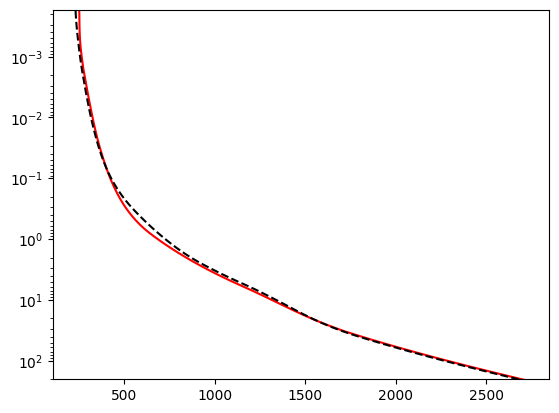

In [7]:
plt.ylim(200,1.7e-4)
plt.semilogy(out['temperature'],out['pressure'],"r", label='Resort-Rebin, Chemical Disequilibrium, Self Consistent Kzz')
plt.semilogy(temp_guess,pressure,color="k",linestyle="--", label='Pre-weighted CK, Chemical Equilibrium')